In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
CSV_DATA = Path().cwd().parent.parent / "data/1_transformed/"

In [2]:
def plot_state_column(df:pd.DataFrame, column:str, color_by:str='segment_id',figsize=(15,3),
                       ylims:list[float]=None, units:str='none', show_mean:bool=True) -> None:
    _ = plt.figure(figsize=figsize)
    _ = plt.hlines(y=df[column].mean(), xmin=1, xmax=df['elapsed_time'].max(), colors='red', linestyles='dashed')
    _ = sns.lineplot(df, x='elapsed_time', y=column, hue=color_by, palette='hls', legend=False)
    _ = plt.grid()
    _ = plt.title(f'{column.upper()} Segments', fontsize=18)
    _ = plt.xlabel('Elapsed Time (seconds)', fontsize=14)
    _ = plt.ylabel(f'{column.upper()} ({units})', fontsize=14)
    
    if ylims is not None:
        _ = plt.ylim(ylims)

# 1. Load Ride Data

In [3]:
df = pd.read_csv(CSV_DATA / "0x66780269.csv")

In [4]:
# How many miles was this ride?
df['delta_dist_ft'].sum() / 5280

20.942177878102125

In [5]:
df.columns

Index(['time', 'ride_id', 'segment_id', 'elevation', 'latitude', 'longitude',
       'ambient_temp_C', 'heart_rate_bpm', 'cadence_rpm', 'is_original_row',
       'elapsed_time', 'delta_time', 'delta_dist_ft', 'heading', 'speed',
       'is_cruising', 'delta_ele_ft', 'grade', 'grade_saturated',
       'elapsed_ascent', 'elapsed_descent', 'elapsed_elevation',
       'filt_ambient_temp_C', 'filt_heart_rate_bpm', 'filt_cadence_rpm',
       'filt_speed', 'filt_grade', 'filt_grade_saturated', 'inst_power'],
      dtype='object')

In [6]:
cols_of_interest = ['time','segment_id','elapsed_time','delta_time','delta_dist_ft','speed','grade_saturated','filt_speed','filt_grade_saturated','inst_power',]
df = df.loc[:,cols_of_interest].copy()
df.head()

,time,segment_id,elapsed_time,delta_time,delta_dist_ft,speed,grade_saturated,filt_speed,filt_grade_saturated,inst_power
0,2024-06-23 11:09:29+00:00,0.0,1.0,1.0,0.000000,0.000000,0.0,0.063616,0.0,0.164611
1,2024-06-23 11:09:30+00:00,0.0,2.0,1.0,0.000000,0.000000,0.0,0.081516,0.0,0.210933
2,2024-06-23 11:09:31+00:00,0.0,3.0,1.0,0.364813,0.248736,0.0,0.099685,0.0,0.257956
3,2024-06-23 11:09:32+00:00,0.0,4.0,1.0,0.000000,0.000000,0.0,0.116345,0.0,0.301078
4,2024-06-23 11:09:33+00:00,0.0,5.0,1.0,0.364813,0.248736,0.0,0.129865,0.0,0.336075


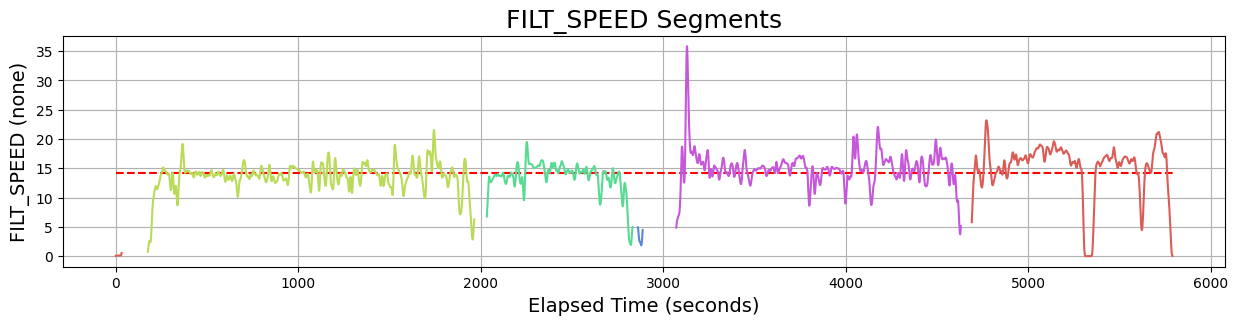

In [7]:
plot_state_column(df, 'filt_speed')

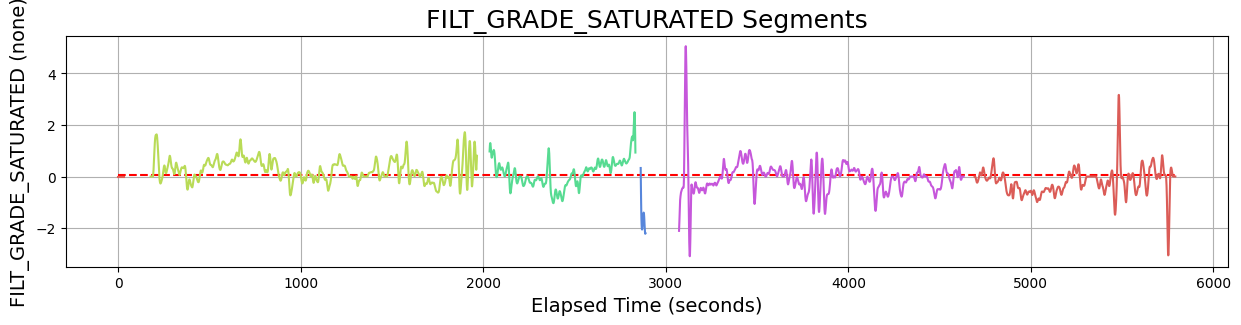

In [8]:
plot_state_column(df, 'filt_grade_saturated')

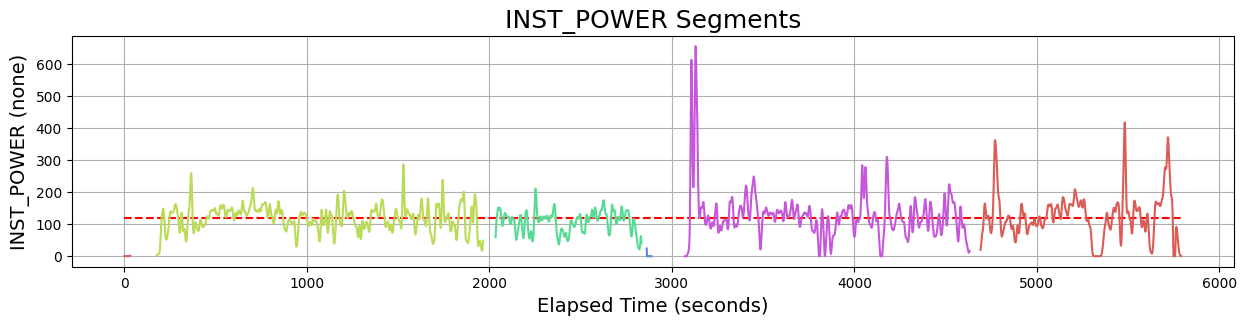

In [9]:
plot_state_column(df, 'inst_power')

In [10]:
def calculate_power_curve(df: pd.DataFrame):
    # Create a set of rolling windows to calculate a MAX over avg(inst_powers[within_window])
    rolling_windows = [4, 5, 10, 20, 30, 60, # seconds
                        2*60, 3*60, 4*60, 5*60, 6*60, 10*60, 20*60, 30*60, 40*60, # minutes
                        60*60, 2*60*60, 3*60*60, 4*60*60] # hours
    rwindow_labels = ['4s', '5s', '10s', '20s', '30s', '1m', # seconds
                        '2m', '3m', '4m', '5m', '6m', '10m', '20m', '30m', '40m', # minutes
                        '1h', '2h', '3h', '4h'] # hours
    label_map = {seconds:label for seconds,label in zip(rolling_windows,rwindow_labels)}

    # Initialize a list to store the peak powers per window
    window_peak_powers = []

    for rwindow in rolling_windows:
        # We should not calculate the peak power for a window that is longer than this value since it is ill defined
        rolling_avg_inst_power = df[['inst_power']].rolling(rwindow, min_periods=rwindow).mean().dropna()
        if rolling_avg_inst_power.shape[0]==0: # all values were np.nan, hence the window is too large for the ride data
            peak_power = np.nan
        else:
            peak_power = max(rolling_avg_inst_power.values)[0]
        window_peak_powers.append({'time_window':label_map[rwindow], 'window_length_seconds':rwindow, 'peak_avg_power':peak_power})
    
    return pd.DataFrame(window_peak_powers)

In [27]:
df_pwr = calculate_power_curve(df=df)
df_pwr

,time_window,window_length_seconds,peak_avg_power
0,4s,4,642.784267
1,5s,5,634.798604
2,10s,10,596.368443
3,20s,20,506.297332
4,30s,30,449.847502
5,1m,60,356.180990
6,2m,120,238.901204
7,3m,180,194.575514
8,4m,240,178.702908
9,5m,300,167.812181


In [31]:
for _, row in df_pwr[['time_window','peak_avg_power']].iterrows():
    print(row['time_window'], row['peak_avg_power'])

4s 642.7842670855964
5s 634.7986040182512
10s 596.3684433570737
20s 506.2973324165071
30s 449.84750170145355
1m 356.18098952220794
2m 238.90120419314127
3m 194.57551401870825
4m 178.70290834339662
5m 167.81218096794748
6m 171.01686885471284
10m 154.6861419153412
20m 133.47139987077804
30m 128.54926976520997
40m 127.33236215494249
1h 121.48153678702576
2h nan
3h nan
4h nan


In [12]:
def plot_ride_power_curve(df:pd.DataFrame, figsize:tuple=(12,4), logscale_base:int=10,
                          title:str='Best Ride Efforts Power Curve'):
    df_pwr = calculate_power_curve(df=df)
    x_col = 'window_length_seconds'

    fig, ax = plt.subplots(1,1, figsize=figsize)
    _ = sns.lineplot(df_pwr, x=x_col, y='peak_avg_power', ax=ax)
    _ = sns.scatterplot(df_pwr, x=x_col, y='peak_avg_power', ax=ax)
    
    def forward(x):
        return np.log10(x) / np.log10(logscale_base)

    def inverse(x):
        return logscale_base**x
    
    if logscale_base==10:
        _ = ax.set_xscale('log')
    else:
        _ = ax.set_xscale('function', functions=(forward,inverse))
    _ = plt.xticks(ticks=df_pwr['window_length_seconds'].values, labels=df_pwr['time_window'].values, rotation=45)
    _ = plt.grid()
    _ = ax.set_axisbelow(True)
    _ = plt.xlabel('Effort Time Duration', fontsize=14)
    _ = plt.ylabel('Maximum Effort Power (W)', fontsize=14)
    _ = plt.title(title, fontsize=18)

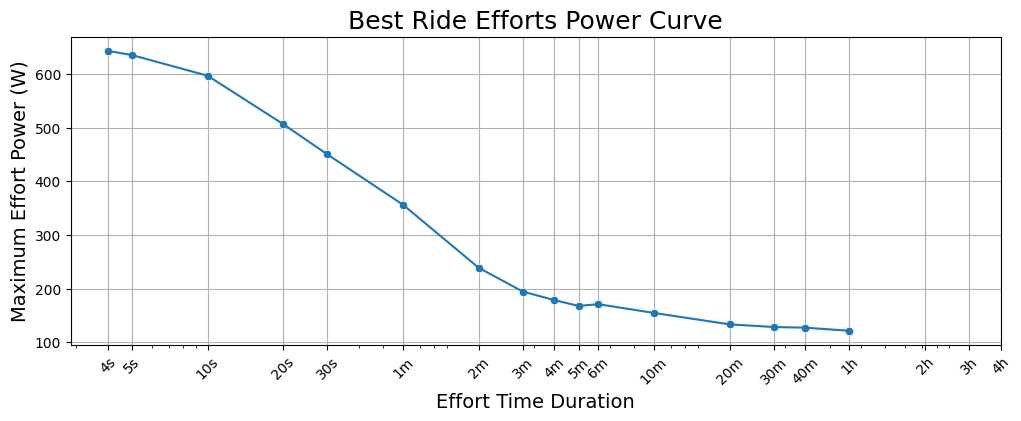

In [13]:
plot_ride_power_curve(df)

# 2. Analyzing a Ride with Heart Rate

In [14]:
df2 = pd.read_csv(CSV_DATA / "0x680b85ff.csv") 
print(f'the ride is {df2["delta_dist_ft"].sum() * 1/5280.0} miles')

the ride is 8.7820293223238 miles


In [15]:
cols_of_interest = ['time','segment_id','elapsed_time','delta_time','delta_dist_ft','speed','grade_saturated','filt_speed','filt_grade_saturated','inst_power',
                    'heart_rate_bpm']
df2 = df2.loc[:,cols_of_interest].copy()
df2.head()

,time,segment_id,elapsed_time,delta_time,delta_dist_ft,speed,grade_saturated,filt_speed,filt_grade_saturated,inst_power,heart_rate_bpm
0,2025-04-25 12:54:23+00:00,0.0,1.0,1.0,0.0,0.0,0.0,1.223479,0.0,3.210762,82.000000
1,2025-04-25 12:54:24+00:00,0.0,2.0,1.0,0.0,0.0,0.0,1.732477,0.0,4.610618,78.000000
2,2025-04-25 12:54:25+00:00,0.0,3.0,1.0,0.0,0.0,0.0,2.263395,0.0,6.141620,78.666667
3,2025-04-25 12:54:26+00:00,0.0,4.0,1.0,0.0,0.0,0.0,2.777634,0.0,7.714051,79.333333
4,2025-04-25 12:54:27+00:00,0.0,5.0,1.0,0.0,0.0,0.0,3.234079,0.0,9.199920,80.000000


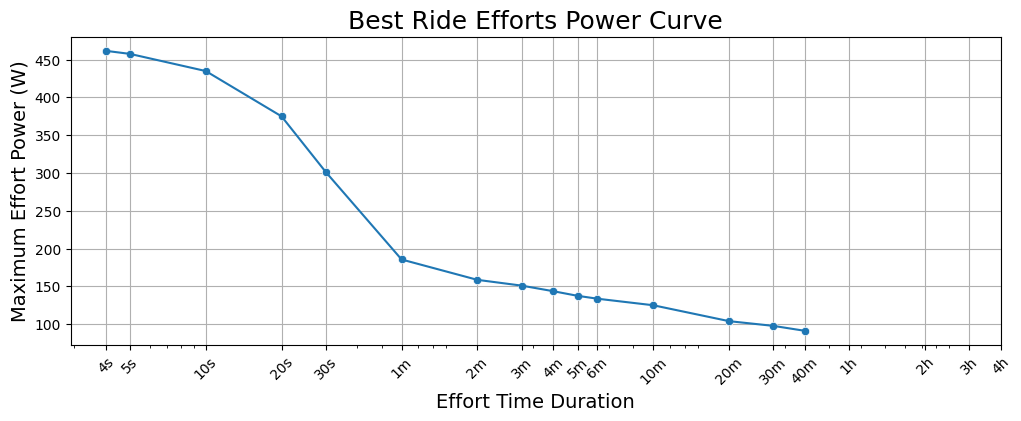

In [16]:
plot_ride_power_curve(df2)

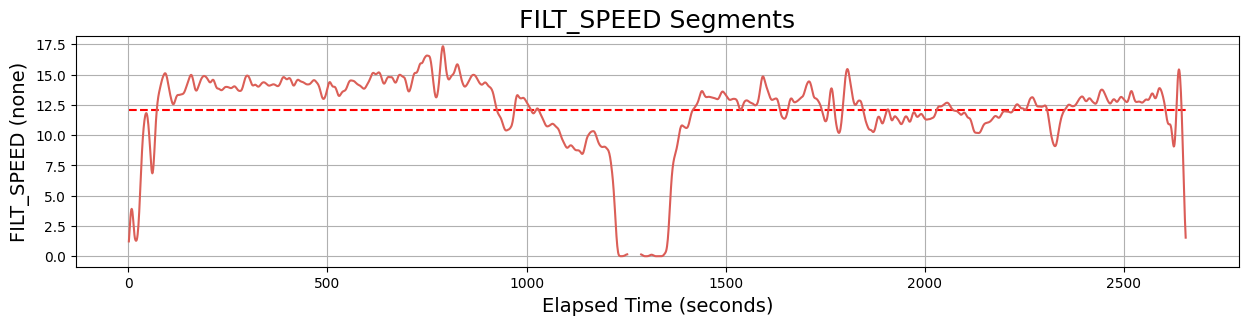

In [17]:
plot_state_column(df2, 'filt_speed')

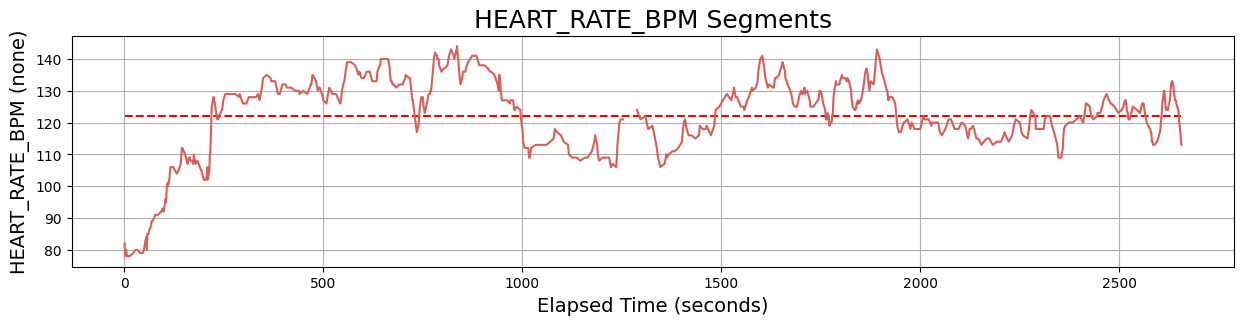

In [18]:
plot_state_column(df2, 'heart_rate_bpm')

In [20]:
longest_ride = '0x66fbe94a.csv'
hardest_otet_ride = '0x670e5fca.csv'

In [21]:
df3 = pd.read_csv(CSV_DATA / longest_ride) 
print(f'the "longest_ride" is {df3["delta_dist_ft"].sum() * 1/5280.0} miles')
df4 = pd.read_csv(CSV_DATA / hardest_otet_ride) 
print(f'the "hardest_otet_ride" is {df4["delta_dist_ft"].sum() * 1/5280.0} miles')

the "longest_ride" is 71.35542799993493 miles
the "hardest_otet_ride" is 69.34708834005495 miles


In [22]:
cols_of_interest = ['time','segment_id','elapsed_time','delta_time','delta_dist_ft','speed','grade_saturated','filt_speed','filt_grade_saturated','inst_power',
                    'heart_rate_bpm']
df3 = df3.loc[:,cols_of_interest].copy()
df4 = df4.loc[:,cols_of_interest].copy()

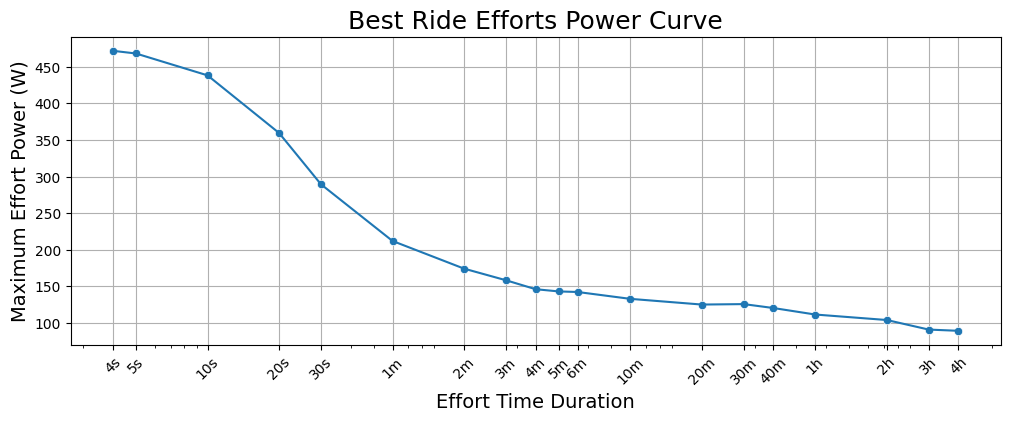

In [23]:
plot_ride_power_curve(df3)

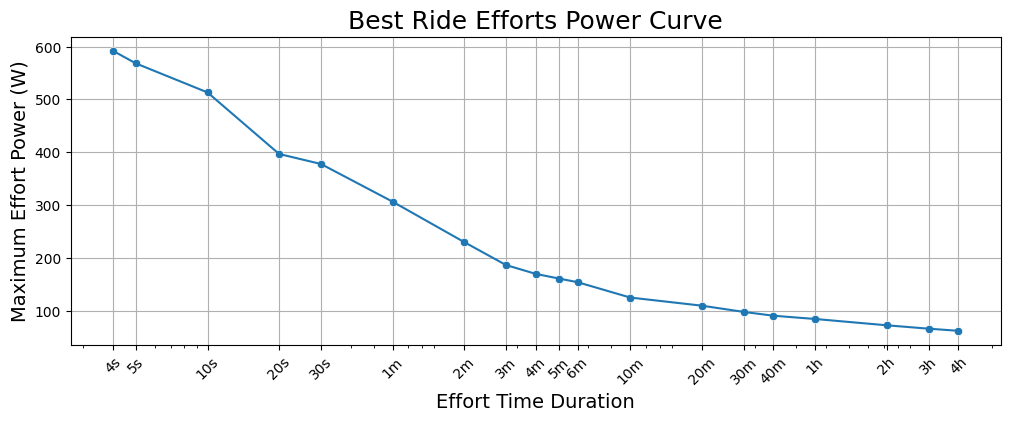

In [24]:
plot_ride_power_curve(df4)

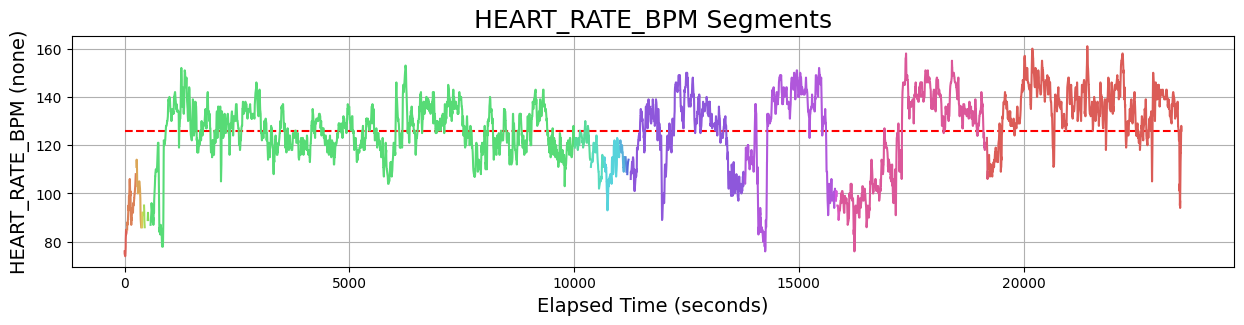

In [25]:
plot_state_column(df3, 'heart_rate_bpm')

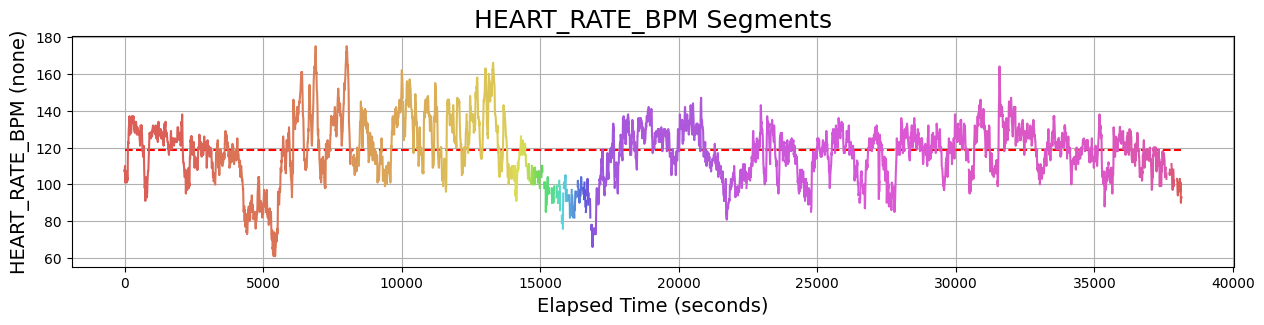

In [26]:
plot_state_column(df4, 'heart_rate_bpm')